#Get .csv formatting for TFlite

In [1]:
#download example from TFLite object detection tutorial
!gsutil cp gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv ./

Copying gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv...
/ [1 files][206.6 KiB/206.6 KiB]                                                
Operation completed over 1 objects/206.6 KiB.                                    


#import repository

In [5]:
!git clone https://github.com/carboni123/weeds-tflite

Cloning into 'weeds-tflite'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (7/7), done.


# Install dependencies and import

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 593kB 7.7MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 122kB 48.0MB/s 
     |████████████████████████████████| 1.2MB 30.7MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 
     |████████████████████████████████| 849kB 44.7MB/s 
     |████████████████████████████████| 645kB 43.9MB/s 
     |████████████████████████████████| 174kB 49.1MB/s 
     |████████████████████████████████| 1.1MB 49.3MB/s 
     |████████████████████████████████| 6.3MB 47.4MB/s 
     |████████████████████████████████| 112kB 54.8MB/s 
     |████████████████████████████████| 686kB 41.9MB/s 
     |████████████████████████████████| 358kB 46.0MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 38.2MB 64kB/s 
     |████████████████████████████████| 194kB 48.6MB/s 


In [4]:
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# read formatting used by tflite interpreter

In [ ]:
df= pd.read_csv('/content/salads_ml_use.csv', header= None)
df.columns= ['Set', 'Path', 'Class', 'xmin', 'ymin', 'u1', 'u2', 'xmax', 'ymax', 'u3', 'u4']

In [ ]:
df.head()

,Set,Path,Class,xmin,ymin,u1,u2,xmax,ymax,u3,u4
0,TEST,gs://cloud-ml-data/img/openimage/103/279324025...,Baked Goods,0.005743,0.084985,NaN,NaN,0.567511,0.735736,NaN,NaN
1,TEST,gs://cloud-ml-data/img/openimage/103/279324025...,Salad,0.402759,0.310473,NaN,NaN,1.000000,0.982695,NaN,NaN
2,TEST,gs://cloud-ml-data/img/openimage/1064/31677074...,Cheese,0.000000,0.000000,NaN,NaN,0.054865,0.480665,NaN,NaN
3,TEST,gs://cloud-ml-data/img/openimage/1064/31677074...,Cheese,0.041131,0.401678,NaN,NaN,0.318230,0.785916,NaN,NaN
4,TEST,gs://cloud-ml-data/img/openimage/1064/31677074...,Cheese,0.116263,0.065161,NaN,NaN,0.451528,0.286489,NaN,NaN


#download dataset

In [11]:
%%shell
mkdir Data
cd Data
cp /content/weeds-tflite/weeds.zip ./
unzip ./weeds.zip
rm -r weeds.zip

Archive:  ./weeds.zip
   creating: test/
 extracting: test/640x480_1-mp4-t-4_jpg.rf.4944ad9e4e85d69031a3663865934f0a.jpg  
 extracting: test/640x480_2-mp4-t-14_jpg.rf.969c95c264ab85834cdffd39d01ff61c.jpg  
 extracting: test/640x480_2-mp4-t-24_jpg.rf.e06f6ed5fb05387ec2b3f9c8bc64e359.jpg  
 extracting: test/640x480_2-mp4-t-9_jpg.rf.787867fc07d60b0466d59612054a8129.jpg  
 extracting: test/640x480_3-mp4-t-27_jpg.rf.118a54fa2a7ea1bdbf3de24693cc72d9.jpg  
 extracting: test/640x480_3-mp4-t-31_jpg.rf.4d8c911380f3b866a111528378f096e3.jpg  
 extracting: test/640x480_4-mp4-t-10_jpg.rf.1376b64c7882047117fd98add0274414.jpg  
 extracting: test/640x480_4-mp4-t-20_jpg.rf.71f7edc40d83e82b54adfb7ed258e385.jpg  
 extracting: test/640x480_4-mp4-t-41_jpg.rf.d69bcea7822aa894454cfe9e4933fd43.jpg  
 extracting: test/640x480_4-mp4-t-44_jpg.rf.22ea5d944c6cb77f36248d799f885c9b.jpg  
 extracting: test/640x480_5-mp4-t-19_jpg.rf.3936dc023f91c62d2fbb1a84475b0be2.jpg  
 extracting: test/640x480_5-mp4-t-26_jpg.rf.4d7c

# convert dataset annotation to df

In [24]:
test_df= pd.read_csv('/content/Data/test/_annotations.csv')
# test_df.head()
valid_df= pd.read_csv('/content/Data/valid/_annotations.csv')
train_df= pd.read_csv('/content/Data/train/_annotations.csv')


# make dataset with salads df formatting 

In [25]:
tflite_list= []
#test

test_df[['xmin','xmax']]= test_df[['xmin', 'xmax']] / test_df.width.max() #normalize x
test_df[['ymin', 'ymax']]= test_df[['ymin', 'ymax']] / test_df.height.max() #normalize y

test_df['filename']=test_df['filename'].apply(lambda row: os.path.join('/content/','Data','test',row)) #full path
test_df[['xmin','ymin','xmax','ymax']]=test_df[['xmin','ymin','xmax','ymax']].apply(lambda rnd: np.round_(rnd,6)) #roundto6

test_df= test_df[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']] #filter columns

test_df['set']= 'TEST' #add TEST label row
test_df= test_df[['set', 'filename', 'class', 'xmin', 'ymin','xmax','ymax']] #organize

#validation
valid_df[['xmin','xmax']]= valid_df[['xmin', 'xmax']] / valid_df.width.max()
valid_df[['ymin', 'ymax']]= valid_df[['ymin', 'ymax']] / valid_df.height.max()

valid_df['filename']=valid_df['filename'].apply(lambda row: os.path.join('/content/','Data','valid',row))
valid_df[['xmin','ymin','xmax','ymax']]=valid_df[['xmin','ymin','xmax','ymax']].apply(lambda rnd: np.round_(rnd,6)) #roundto6

valid_df= valid_df[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']] 

valid_df['set']= 'VALIDATE'
valid_df= valid_df[['set', 'filename', 'class', 'xmin', 'ymin','xmax','ymax']]

#train
train_df[['xmin','xmax']]= train_df[['xmin', 'xmax']] / train_df.width.max()
train_df[['ymin', 'ymax']]= train_df[['ymin', 'ymax']] / train_df.height.max()

train_df['filename']=train_df['filename'].apply(lambda row: os.path.join('/content/','Data','train',row))
train_df[['xmin','ymin','xmax','ymax']]=train_df[['xmin','ymin','xmax','ymax']].apply(lambda rnd: np.round_(rnd,6)) #roundto6

train_df= train_df[['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']] 

train_df['set']= 'TRAIN'
train_df= train_df[['set', 'filename', 'class', 'xmin', 'ymin','xmax','ymax']]

In [26]:
test_list, valid_list, train_list=[], [], []
for i,row in test_df.iterrows():
  test_list.append([row['set'],row['filename'],row['class'], row['xmin'], row['ymin'], '', '', row['xmax'], row['ymax'], '', ''])
for i,row in valid_df.iterrows():
  valid_list.append([row['set'],row['filename'],row['class'], row['xmin'], row['ymin'], '', '', row['xmax'], row['ymax'], '', ''])
for i,row in train_df.iterrows():
  train_list.append([row['set'],row['filename'],row['class'], row['xmin'], row['ymin'], '', '', row['xmax'], row['ymax'], '', ''])

In [27]:
tflite_list.append(pd.DataFrame(test_list))
tflite_list.append(pd.DataFrame(valid_list))
tflite_list.append(pd.DataFrame(train_list))
pd.concat(tflite_list, axis=0).to_csv('train.csv', header= False, index= False)

# Train

In [28]:
spec = model_spec.get('efficientdet_lite0')
# 'efficientdet_lite0' 'efficientdet_lite1' 'efficientdet_lite2' 'efficientdet_lite3' 'efficientdet_lite4'

In [29]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('/content/train.csv')

In [30]:
model = object_detector.create(train_data, model_spec=spec, epochs=50, batch_size=4, train_whole_model=True, validation_data=validation_data)


Epoch 1/50
131/131 [==============================] - 82s 186ms/step - det_loss: 1.5053 - cls_loss: 0.8575 - box_loss: 0.0130 - reg_l2_loss: 0.0630 - loss: 1.5683 - learning_rate: 0.0065 - gradient_norm: 3.3360 - val_det_loss: 1.0146 - val_cls_loss: 0.5160 - val_box_loss: 0.0100 - val_reg_l2_loss: 0.0631 - val_loss: 1.0776
Epoch 2/50
131/131 [==============================] - 21s 162ms/step - det_loss: 1.0591 - cls_loss: 0.5503 - box_loss: 0.0102 - reg_l2_loss: 0.0631 - loss: 1.1222 - learning_rate: 0.0050 - gradient_norm: 4.0175 - val_det_loss: 0.8560 - val_cls_loss: 0.4337 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0632 - val_loss: 0.9192
Epoch 3/50
131/131 [==============================] - 21s 163ms/step - det_loss: 0.8856 - cls_loss: 0.4820 - box_loss: 0.0081 - reg_l2_loss: 0.0632 - loss: 0.9488 - learning_rate: 0.0050 - gradient_norm: 4.1156 - val_det_loss: 0.8076 - val_cls_loss: 0.4476 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0633 - val_loss: 0.8709
Epoch 4/50
131/131 [=====

In [31]:
model.evaluate(test_data)


1/1 [==============================] - 6s 6s/step



{'AP': 0.35208306,
 'AP50': 0.656872,
 'AP75': 0.3438415,
 'AP_/weed': 0.35208306,
 'APl': 0.40347615,
 'APm': 0.38481575,
 'APs': 0.18783067,
 'ARl': 0.5090909,
 'ARm': 0.57272726,
 'ARmax1': 0.13285714,
 'ARmax10': 0.43571427,
 'ARmax100': 0.5378571,
 'ARs': 0.38947368}

In [32]:
model.export(export_dir='/content/')


In [33]:
model.evaluate_tflite('model.tflite', test_data)


31/31 [==============================] - 75s 2s/step



{'AP': 0.3386969,
 'AP50': 0.65197194,
 'AP75': 0.31112346,
 'AP_/weed': 0.3386969,
 'APl': 0.40689868,
 'APm': 0.36493263,
 'APs': 0.1779337,
 'ARl': 0.46818182,
 'ARm': 0.5,
 'ARmax1': 0.13214286,
 'ARmax10': 0.43214285,
 'ARmax100': 0.47142857,
 'ARs': 0.3263158}

#inference test(with tensorflow)

In [34]:
import cv2
from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

In [35]:
import cv2
from PIL import Image
import time

#tensorflow is used here but it shouldnt be used with TFlite. Check the other scripts.

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  
  start_time = time.monotonic()
  interpreter.invoke()
  elapsed_ms = (time.monotonic() - start_time) * 1000
  print(f'Inference Time: {np.round_(elapsed_ms,2)} ms')

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image

    color = [int(c) for c in COLORS[class_id]]
    # color= (255, 0, 0) #Blue
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

Inference Time: 2372.16 ms


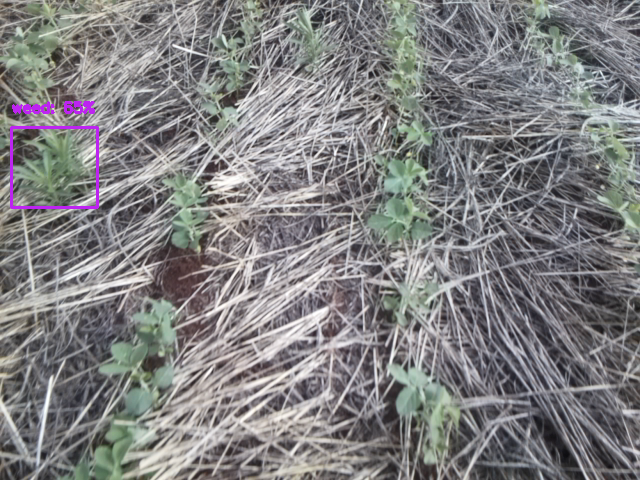

In [36]:
model_path= '/content/model.tflite'
DETECTION_THRESHOLD = 0.3
IMG_PATH= '/content/weeds-tflite/img_1597293167.46.png'

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMG_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

# Time inference

In [41]:
# def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
image_path= IMG_PATH
interpreter= interpreter
threshold= 0.3

# Load the input shape required by the model
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

# Load the input image and preprocess it
preprocessed_image, original_image = preprocess_image(
    image_path,
    (input_height, input_width)
  )
set_input_tensor(interpreter, preprocessed_image)

In [42]:
%%timeit
interpreter.invoke()


1 loop, best of 5: 2.35 s per loop


In [43]:
# Get all outputs from the model
boxes = get_output_tensor(interpreter, 0)
classes = get_output_tensor(interpreter, 1)
scores = get_output_tensor(interpreter, 2)
count = int(get_output_tensor(interpreter, 3))

results = []
for i in range(count):
  if scores[i] >= threshold:
    result = {
      'bounding_box': boxes[i],
      'class_id': classes[i],
      'score': scores[i]
    }
    results.append(result)
results= results

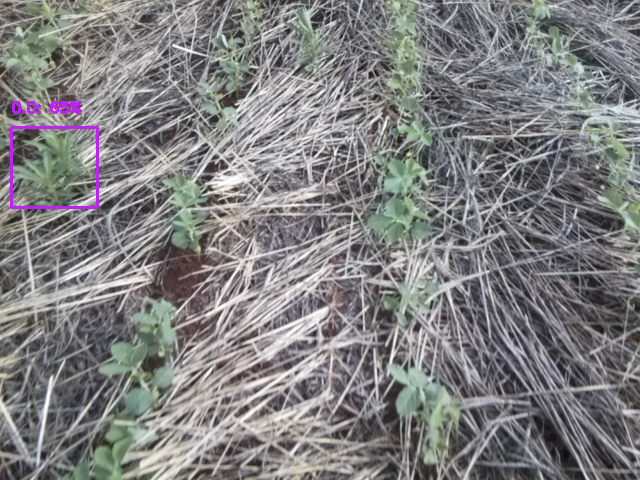

In [44]:

# Plot the detection results on the input image
original_image_np = original_image.numpy().astype(np.uint8)
for obj in results:
  # Convert the object bounding box from relative coordinates to absolute
  # coordinates based on the original image resolution
  ymin, xmin, ymax, xmax = obj['bounding_box']
  xmin = int(xmin * original_image_np.shape[1])
  xmax = int(xmax * original_image_np.shape[1])
  ymin = int(ymin * original_image_np.shape[0])
  ymax = int(ymax * original_image_np.shape[0])

  # Find the class index of the current object
  class_id = int(obj['class_id'])

  # Draw the bounding box and label on the image
  color = [int(c) for c in COLORS[class_id]]
  cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
  # Make adjustments to make the label visible for all objects
  y = ymin - 15 if ymin - 15 > 15 else ymin + 15
  label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
  cv2.putText(original_image_np, label, (xmin, y),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Return the final image
original_uint8 = original_image_np.astype(np.uint8)

Image.fromarray(original_uint8)